In [55]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, Annotated
from dotenv import load_dotenv
from pydantic import BaseModel, Field
import operator

In [56]:
load_dotenv()

True

In [57]:
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite")

In [58]:
class evalSchema(BaseModel):
    feedback: str = Field(description="Detailed feedback for the IELTS writing test task 2")
    score: int = Field(description="Score out of 9", ge=0, le=9)

In [59]:
stModel = model.with_structured_output(evalSchema)

In [60]:
test_ = """
Task:
In many countries, people are driving cars more frequently instead of using public transport.
What are the reasons for this trend?
What problems does it cause, and what solutions can be suggested?

Answer:
People prefer cars over public transport in many countries.
Cars have many conveniences. People choose cars because cars are faster to travel, comfortable and can go anywhere they want. The major disadvantage of public transport is you have to wait for its departure time. It is possible that your time do not match with the vehicles schedule, which is also inconvenient. With cars, you can go whenever you want. Also, you can reach exactly where you want to be unlike public transport.
But as uses of cars are increasing day by day, so is the pollution. Cars uses fossil fuel to run its engine, and it produce carbon mono-oxide as a byproduct. As a result, global warming is rapidly increasing. Traffic is another result of cars. By one public transport like bus can travel 40 people, which is double in size of a car. But in a car, only 4 to 5 people can travel.
From the above discussion, it is clear that, using cars may have instant benefits, but in the long run causes more damage. One effective solution would be electric cars. Governments can make policy that everyone have to use electric cars or similar policy like Chaina, where you have to pay extra tax if you are using cars with fuel engine.
Overall, it is clear that cars are damaging our world and it may not be reversable. So, we need to think about it thoroughly.
"""

In [61]:
# prompt = f"Generate a detailed feedback for the following IELTS writing test task 2 and give a score out of 9:\n{test_}"
# result = stModel.invoke(prompt)

In [62]:
# result

In [63]:
# define the state
class ieltsState(TypedDict):
    test: str
    grammarFeedback: str
    languageFeedback: str
    # spellingFeedback: str
    # contentAcc: str
    overallFeedback: str
    scores: Annotated[list[int], operator.add]
    avgScore: float


In [64]:
def eval_grammar(state: ieltsState):
    test = state['test']
    prompt = f"evaluate the grammar quality of the following IELTS writing test task 2 and give a score out of 9: \n {test}"
    result = stModel.invoke(prompt)

    return {'grammarFeedback': result.feedback, 'scores': [result.score]}

In [65]:
def eval_language(state: ieltsState):
    test = state['test']
    prompt = f"evaluate the language quality of the following IELTS writing test task 2 and give a score out of 9: \n {test}"
    result = stModel.invoke(prompt)

    return {'languageFeedback': result.feedback, 'scores': [result.score]}

In [66]:
# def eval_spelling(state: ieltsState):
#     test = state['test']
#     prompt = f"evaluate the spelling quality of the following IELTS writing test task 2 and give a score out of 9: \n {test}"
#     result = stModel.invoke(prompt)

#     return {'spellingFeedback': result.feedback, 'scores': [result.score]}

In [67]:
# def eval_contentAcc(state: ieltsState):
#     test = state['test']
#     prompt = f"evaluate the content accuracy of the following IELTS writing test task 2 and give a score out of 9: \n {test}"
#     result = stModel.invoke(prompt)

#     return {'contentAcc': result.feedback, 'scores': [result.score]}

In [68]:
def overall_eval(state: ieltsState):
    grammarFeedback = state['grammarFeedback']
    languageFeedback = state['languageFeedback']
    # spellingFeedback = state['spellingFeedback']
    # contentAcc = state['contentAcc']
    
    prompt = f"Based on the following feedbacks create a summarized feedback \n grammer feedback - {grammarFeedback} \n language feedback - {languageFeedback}"
    
    result = model.invoke(prompt)

    avgScore = sum(state['scores']) / len(state['scores'])

    return {'overallFeedback': result.content, 'avgScore': avgScore}

In [69]:

graph = StateGraph(ieltsState)

graph.add_node('evaluate grammar', eval_grammar)
graph.add_node('evaluate language', eval_language)
# graph.add_node('evaluate spelling', eval_spelling)
# graph.add_node('evaluate content accuracy', eval_contentAcc)
graph.add_node('overall evaluation', overall_eval)

graph.add_edge(START, 'evaluate grammar')
graph.add_edge(START, 'evaluate language')
# graph.add_edge(START, 'evaluate spelling')
# graph.add_edge(START, 'evaluate content accuracy')

graph.add_edge('evaluate grammar', 'overall evaluation')
graph.add_edge('evaluate language', 'overall evaluation')
# graph.add_edge('evaluate spelling', 'overall evaluation')
# graph.add_edge('evaluate content accuracy', 'overall evaluation')

graph.add_edge('overall evaluation', END)

workflow = graph.compile()

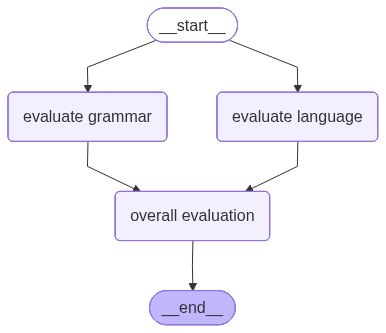

In [70]:
from IPython.display import Image, display

display(Image(workflow.get_graph().draw_mermaid_png()))

In [71]:
result = workflow.invoke({'test': test_})

In [72]:
result

{'test': '\nTask:\nIn many countries, people are driving cars more frequently instead of using public transport.\nWhat are the reasons for this trend?\nWhat problems does it cause, and what solutions can be suggested?\n\nAnswer:\nPeople prefer cars over public transport in many countries.\nCars have many conveniences. People choose cars because cars are faster to travel, comfortable and can go anywhere they want. The major disadvantage of public transport is you have to wait for its departure time. It is possible that your time do not match with the vehicles schedule, which is also inconvenient. With cars, you can go whenever you want. Also, you can reach exactly where you want to be unlike public transport.\nBut as uses of cars are increasing day by day, so is the pollution. Cars uses fossil fuel to run its engine, and it produce carbon mono-oxide as a byproduct. As a result, global warming is rapidly increasing. Traffic is another result of cars. By one public transport like bus can 